# Boosting classifier accuracy by grouping categories

In this tutorial, we will split the 1000 image-categories, which our model was trained to classify, into three disjoint sets: *dogs*, *cats*, and *other* (anything that isn't a dog or a cat). We will demonstrate how a classifier with low accuracy on the original 1000-class problem can have a sufficiently high accuracy on the simpler 3-class problem. We will write a Python script that reads images from the camera, barks when it sees a dog, and meows when it sees a cat.

[![screenshot](https://microsoft.github.io/ELL/tutorials/Boosting-classifier-accuracy-by-grouping-categories/thumbnail.png)](https://youtu.be/SOmV8tzg_DU)

#### Prerequisites

* Complete the basic tutorial, [Getting started with image classification on Raspberry Pi](https://notebooks.azure.com/microsoft-ell/libraries/tutorials/html/Getting%20started%20with%20image%20classification%20on%20the%20Raspberry%20Pi%20%28Part%201%29.ipynb), to learn how to use an ELL model from the Gallery.

## Overview

The pre-trained models in the [ELL gallery](https://microsoft.github.io/ELL/gallery/) are trained to identify 1000 different image categories (see the category names [here](https://github.com/Microsoft/ELL-models/raw/master/models/ILSVRC2012/categories.txt)). Often times, we are only interested in a subset of these categories and we don't require the fine-grained categorization that the model was trained to provide. For example, we may want to classify images of dogs versus images of cats, whereas the model is actually trained to distinguish between 6 different varieties of cat and 106 different varieties of dog.

The dogs versus cats classification problem is easier than the original 1000 class problem, so a model that isn't very accurate on the original problem may be perfectly adequate on the simpler problem. Specifically, we will use a model that has an error rate of 64% on the 1000-class problem, but only 5% on the 3-class problem. We will build an application that grabs a frame from a camera, plays a barking sound when it recognizes one of the dog varieties, and plays a meow sound when it recognizes one of the cat varieties.

As a pre-step, we need to install `ell` in the Azure virtual machine.

In [1]:
!conda config --prepend channels conda-forge --prepend channels microsoft-ell
!conda install -y ell

Fetching package metadata ...............
Solving package specifications: .

# All requested packages already installed.
# packages in environment at /home/nbcommon/anaconda3_431:
#
ell                       0.0.1            py36h0a24ad1_0    microsoft-ell


## Build a pre-trained model

Start by repeating the steps of the basic tutorial, [Getting Started with Image Classification on Raspberry Pi](https://notebooks.azure.com/microsoft-ell/libraries/tutorials/html/Getting%20started%20with%20image%20classification%20on%20the%20Raspberry%20Pi%20%28Part%201%29.ipynb). This time, specify the Gallery model by name, specifically one that is faster and less accurate. As before, download the model and compile it for the Raspberry Pi.

In [4]:
from ell.pretrained_model import PretrainedModel
import ell.platform

pretrained_model = PretrainedModel('d_I160x160x3NCMNCMNBMNBMNBMNBMNC1A')
pretrained_model.download('boosting', rename='model')
pretrained_model.build()

compiling...
generating python interfaces for model in boosting\host
C:\Users\rdeline\AppData\Local\Continuum\Miniconda3\Library\bin\swig -python -c++ -Fmicrosoft -py3 -outdir boosting\host -IC:\ID\ELL\build\interfaces\python\package\ell/headers/common -IC:\ID\ELL\build\interfaces\python\package\ell/headers/common/include -IC:\ID\ELL\build\interfaces\python\package\ell/headers/emitters -o boosting\host\modelPYTHON_wrap.cxx boosting\host\model.i
running opt...
C:\Users\rdeline\AppData\Local\Continuum\Miniconda3\Library\bin\opt boosting\host\model.bc -o boosting\host\model.opt.bc -O3
running llc...
C:\Users\rdeline\AppData\Local\Continuum\Miniconda3\Library\bin\llc boosting\host\model.opt.bc -o boosting\host\model.obj -filetype=obj -O3 -relocation-model=pic
building...
cmake -G Visual Studio 14 2015 Win64 -DPROCESSOR_HINT=haswell .
-- The C compiler identification is MSVC 19.0.24215.1
-- The CXX compiler identification is MSVC 19.0.24215.1
-- Check for working C compiler using: Visual St

We read in all 1000 categories from the category file. Handily, all the dog categories are clustered together in the list, as are the cats.

In [6]:
categories = [line.strip('\n') for line in open('boosting/categories.txt', 'r').readlines()]
dogs = categories[151:270]
cats = categories[281:294]

## Classify dogs and cats

Run the model on some test images and see whether the highest-confidence label is in the dog or cat set.

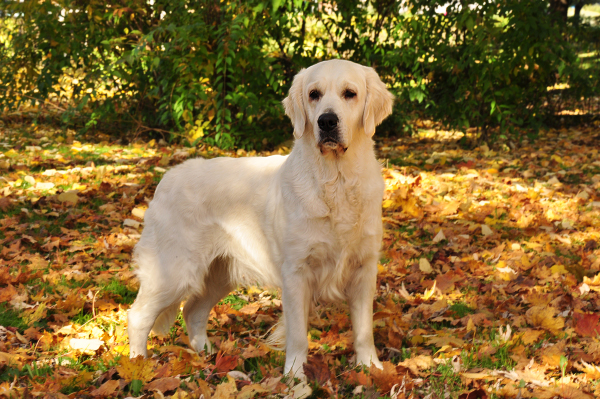

DOG Great Pyrenees


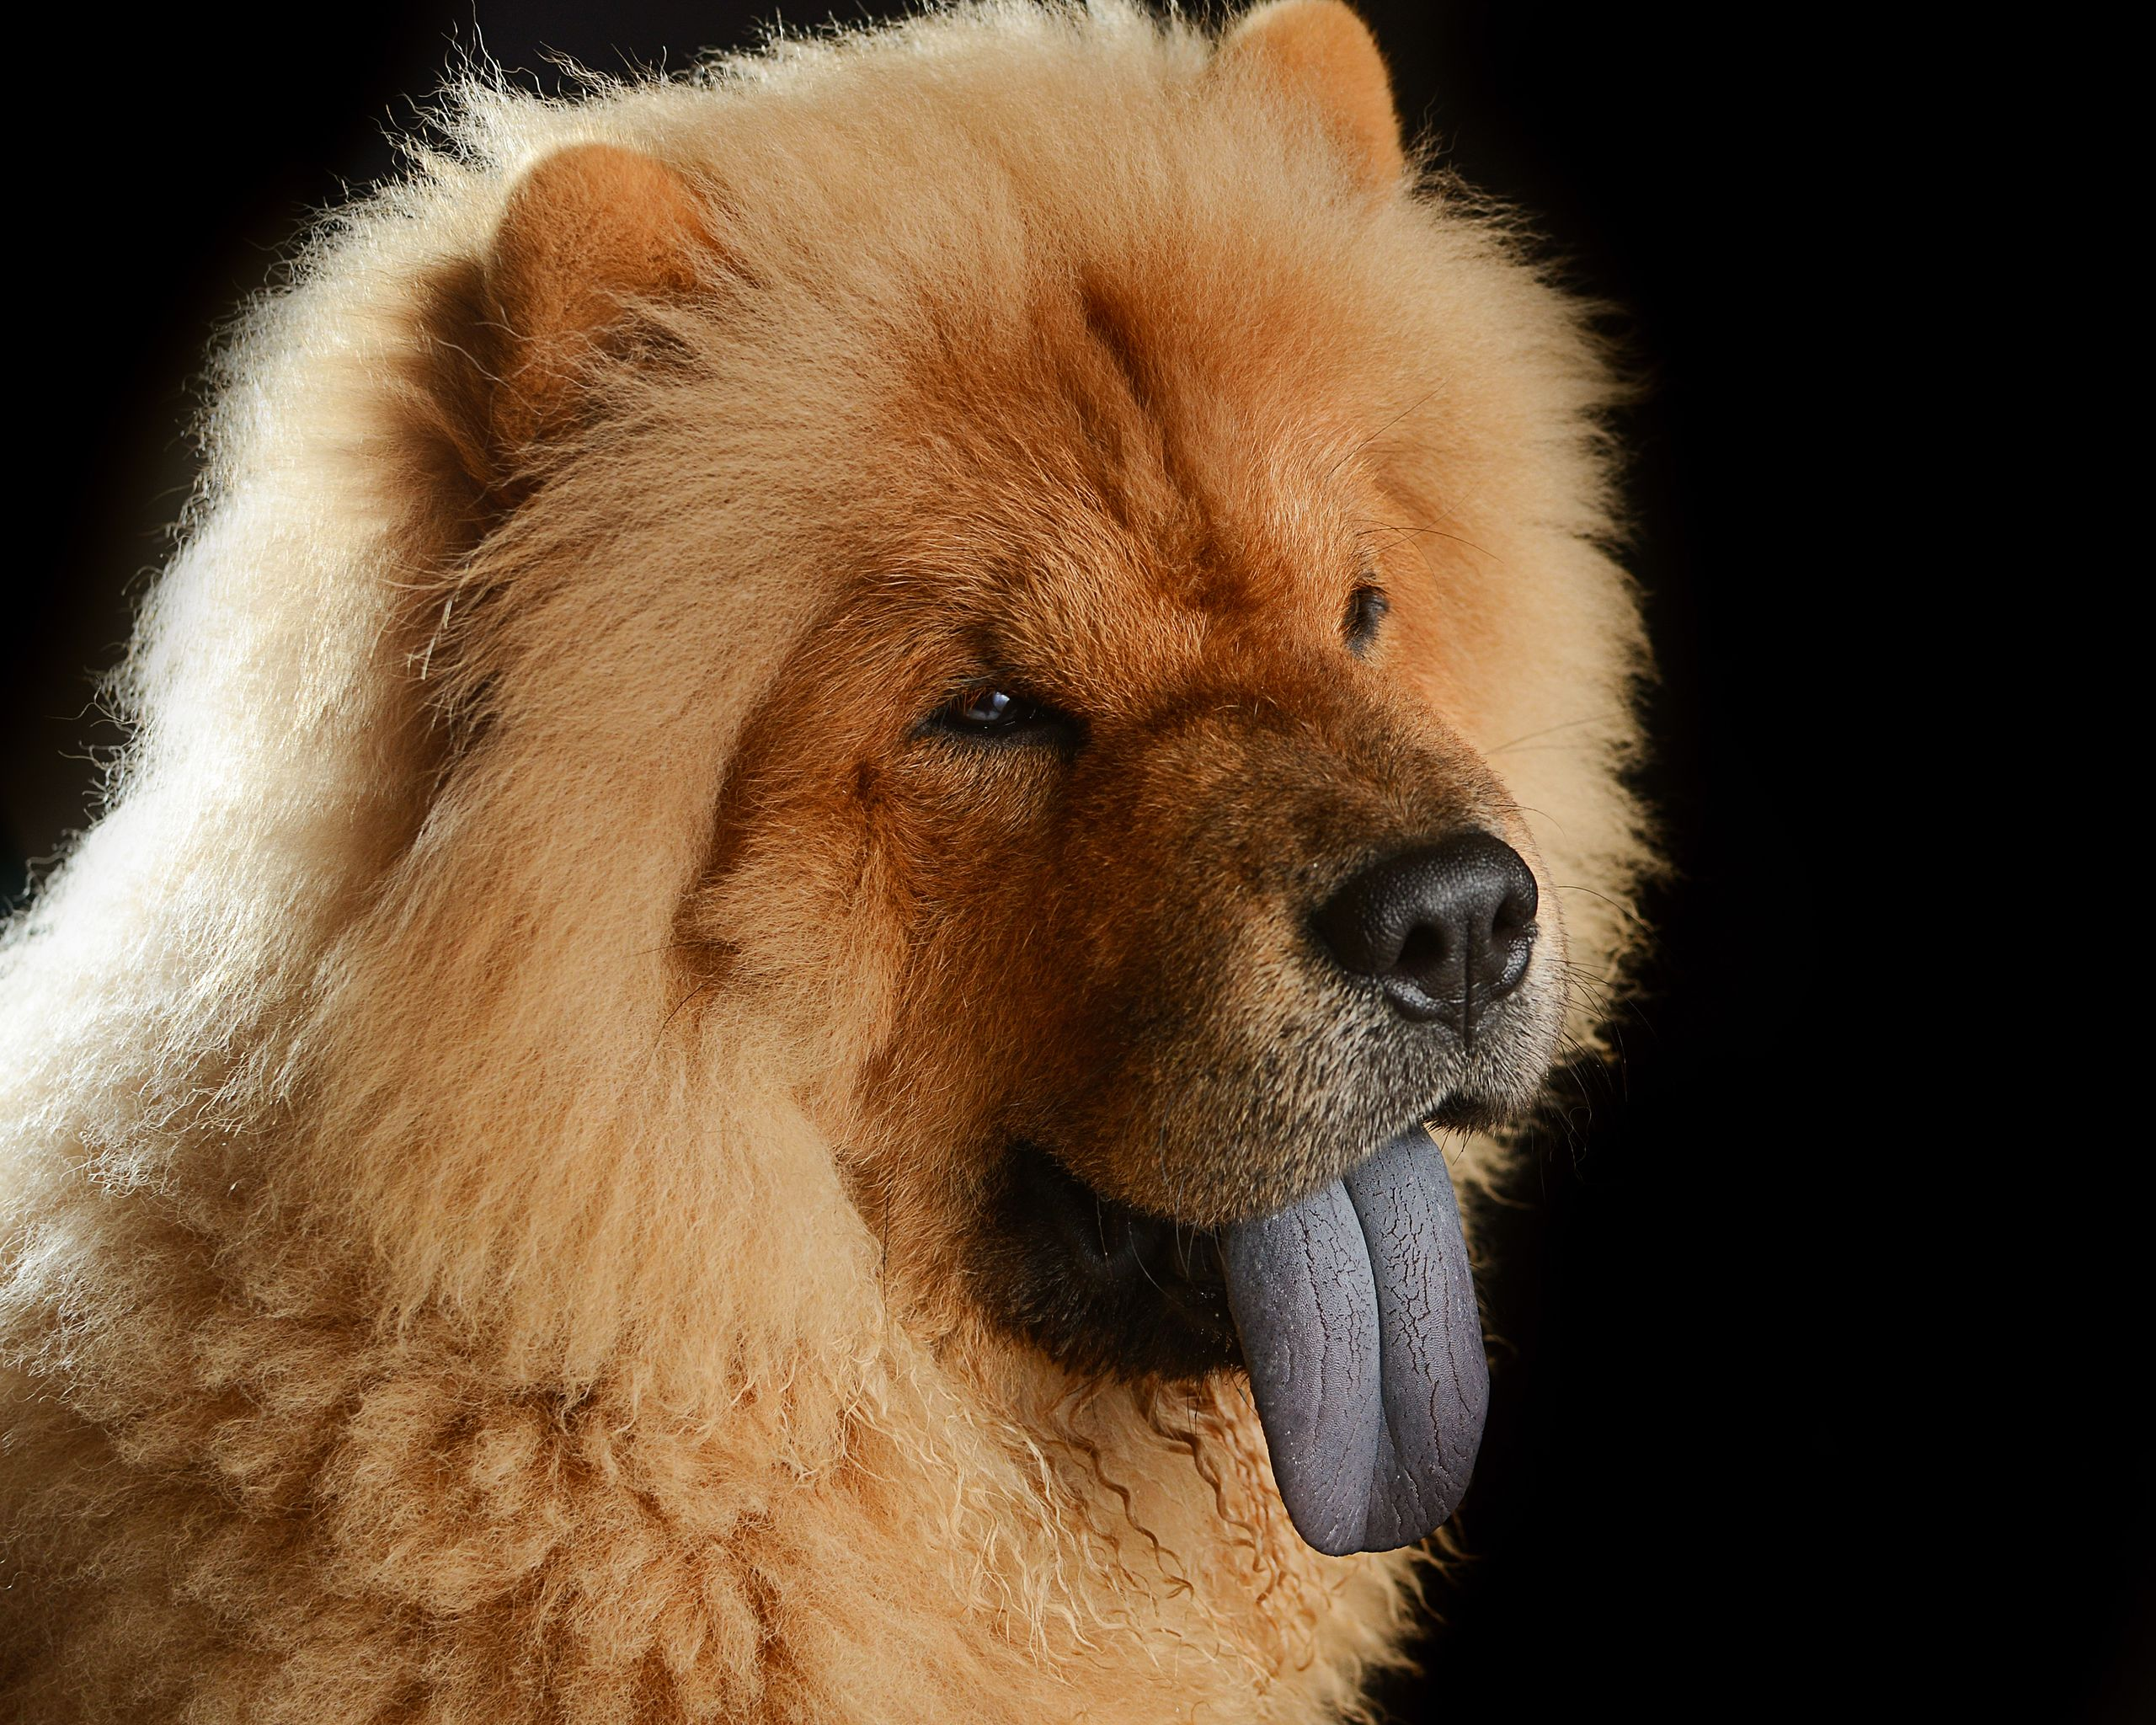

oops, no prediction


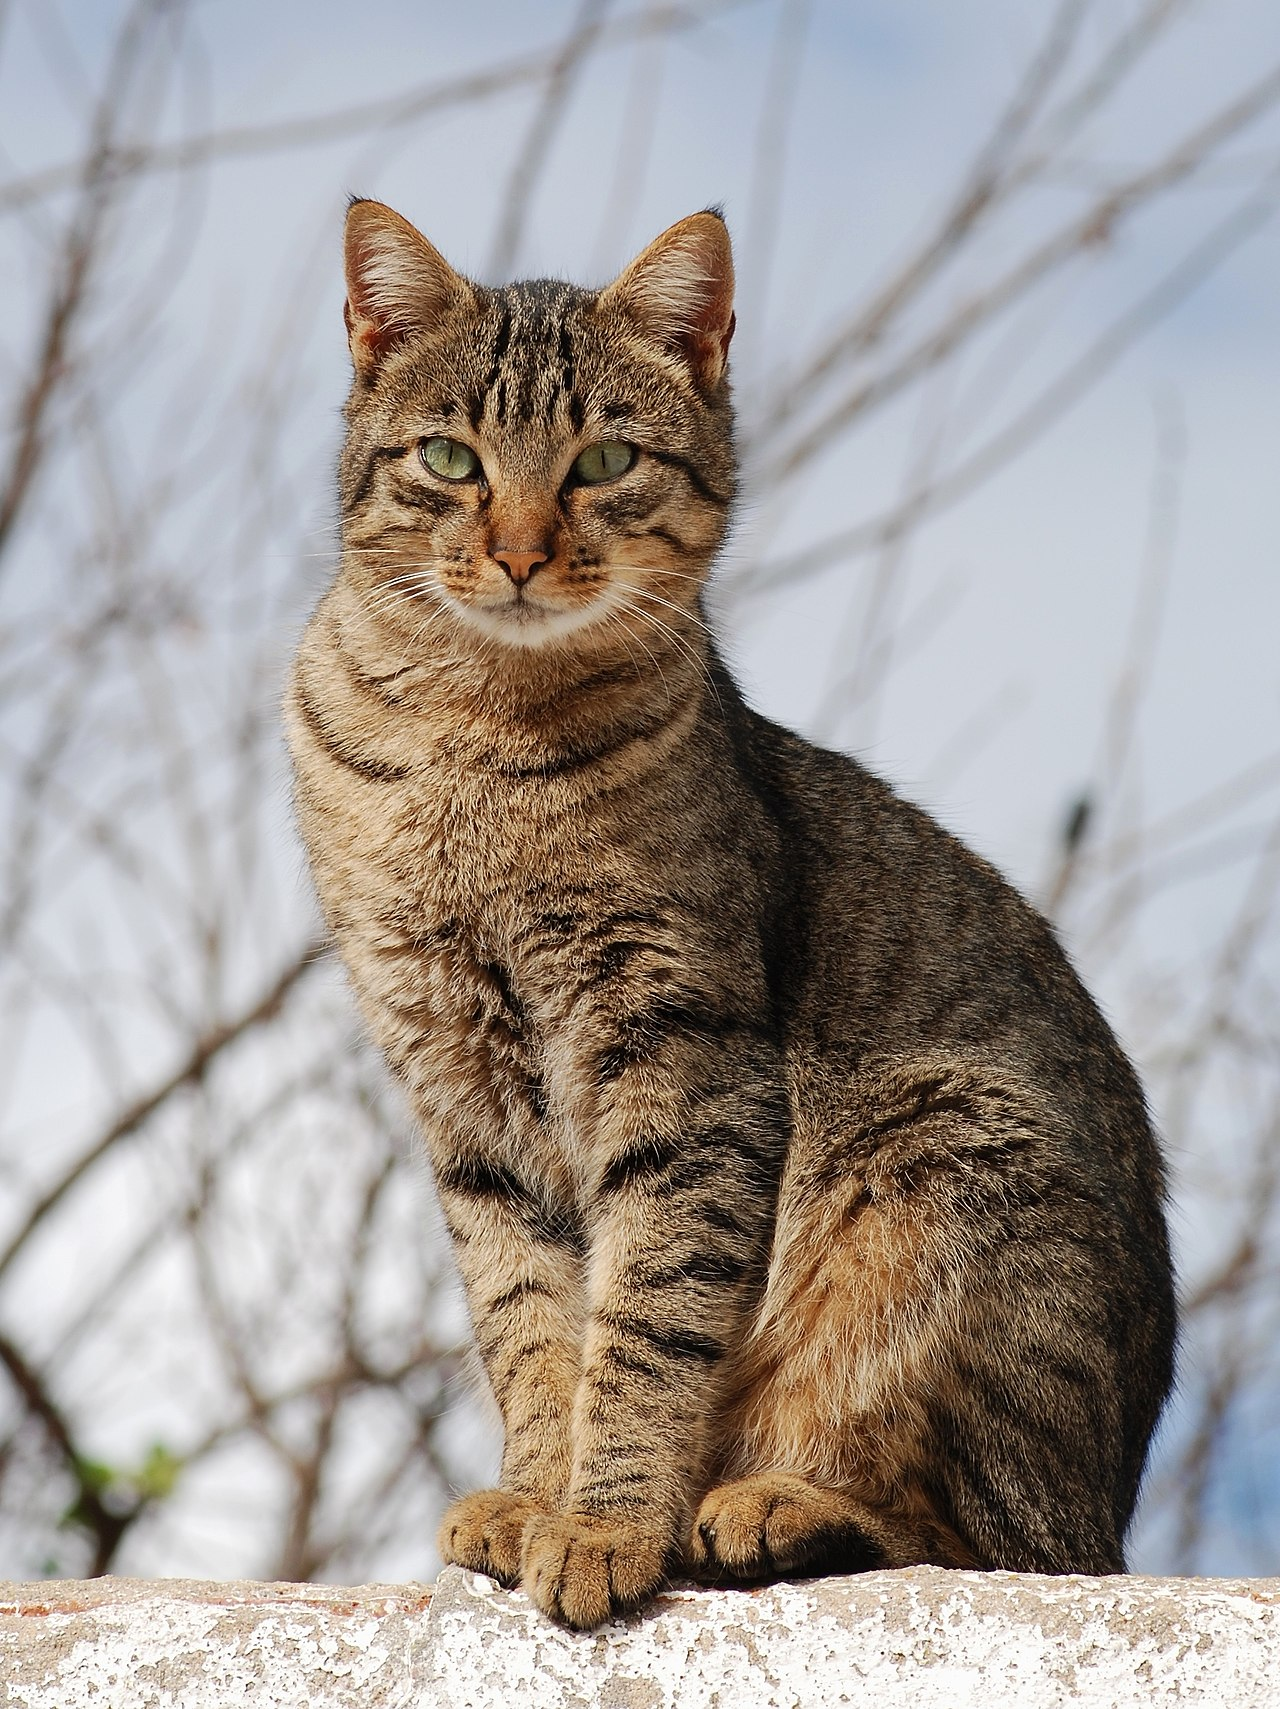

other: sock


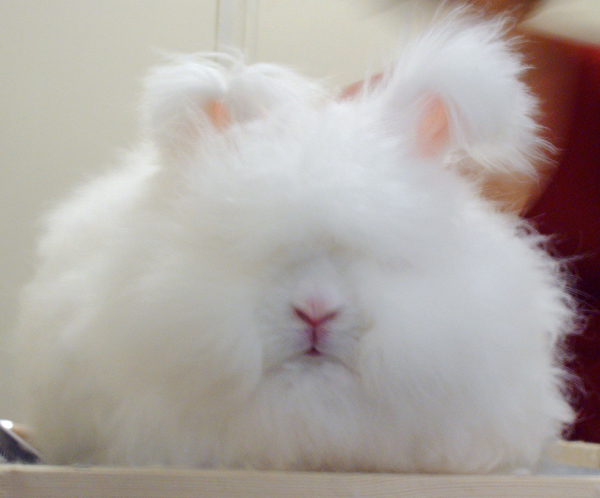

other: Angora, Angora rabbit


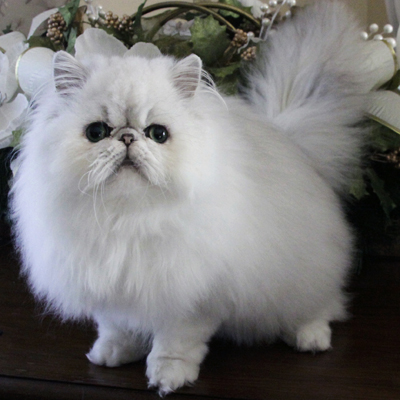

other: Angora, Angora rabbit


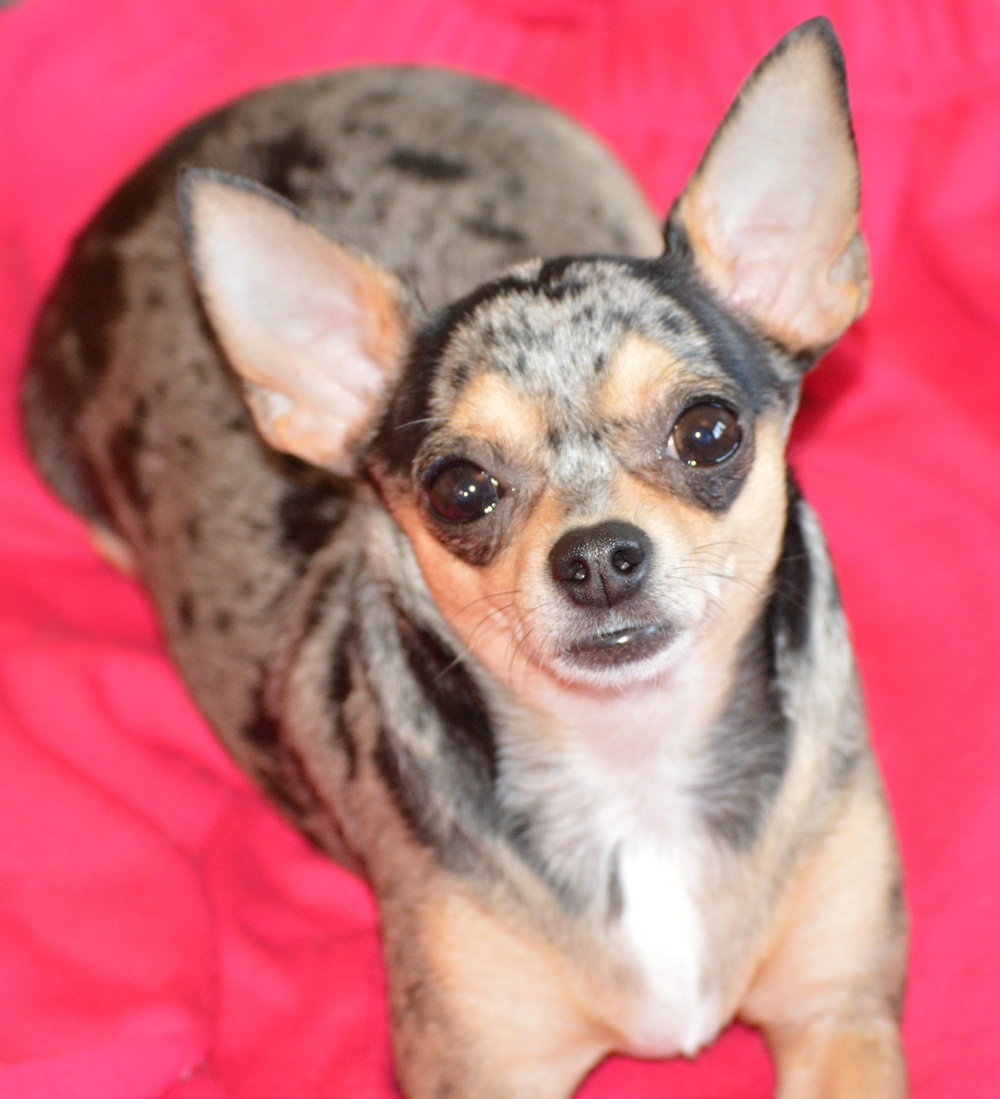

DOG pug, pug-dog


In [22]:
import cv2
from IPython.core.display import Image, display
import urllib.request

model = pretrained_model.load()

test_set = [
    "https://upload.wikimedia.org/wikipedia/commons/5/52/WizzdomOfSoulcharisma.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/a/aa/03_Bokeh_the_Chow.jpg/2560px-03_Bokeh_the_Chow.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/thumb/4/4d/Cat_November_2010-1a.jpg/1280px-Cat_November_2010-1a.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/f/f3/Englishangora.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/3/38/Shaded_silver_Persian_Cat_Missionhill_Cosmic_Rainstorm.jpg",
    "https://upload.wikimedia.org/wikipedia/commons/d/dc/Chihuahua_Blue_Merle.jpg",
]

for image_url in test_set:
    image_path, _ = urllib.request.urlretrieve(image_url, "boosting/testimage.jpg")
    image = cv2.imread(image_path)
    display(Image(filename=image_path, width=200))

    data = pretrained_model.prepare_image(image)

    predictions = model.predict(data)
    top5 = helper.get_top_n(predictions, 5)
    if len(top5) > 0:
        (index,_) = top5[0]
        label = categories[index]
        
        if label in dogs:
            print('DOG', label)
        elif label in cats:
            print('CAT', label)
        else:
            print('other:', label)
    else:
        print('oops, no prediction')